In [1]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import math
import sys
import os
from Generate_data_activity import Generate_data
sys.path.append("/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis")
from Manifold_Analysis import Manifold_analysis
sys.path.append("/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif")

from algos.agents import A2CAgent
from algos.models import ActorCnn, CriticCnn
from algos.preprocessing.stack_frame import preprocess_frame, stack_frame

# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cross_decomposition import CCA
import pandas as pd
import seaborn as sns
import cv2
from tabulate import tabulate


import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


Device:  cpu


# A2C model

In [12]:
LENGTH_TRIAL = 500
EPISODES = 10

In [13]:
Generate_DATA = Generate_data(device)
Liste_activation,Final_score,Liste_position_agent,Liste_position_alien,Liste_action_agent= Generate_DATA.run_episodes(structure_network = "a2c",length_trial = LENGTH_TRIAL,number_episode = EPISODES)

/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_1000.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_2000.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_3000.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_4000.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_5000.pt

Episode :0 	Agent number :0 	Final score: 200.00 	Number of steps: 947
Episode :1 	Agent number :0 	Final score: 465.00 	Number of steps: 917
Episode :2 	Agent number :0 	Final score: 135.00 	Nu

## Preprocessing

In [14]:
Names_hook = ["Conv_1","Conv_2","Conv_3","fc1"]
analysis = Manifold_analysis(LENGTH_TRIAL)
Prepro_length = True
activity_layer = [[[[] for i in range(len(Names_hook))] for j in range(6)] for episode in range(EPISODES)]

for agent_number in range(6):
    print("agent_number",agent_number)
    for layer in range(len(Names_hook)):
        for episode in range(EPISODES):
            activity_layer[episode][agent_number][layer] = analysis.prepro(Liste_activation[episode][agent_number][layer],Prepro_length)

agent_number 0
agent_number 1
agent_number 2
agent_number 3
agent_number 4
agent_number 5


## PCA

In [5]:

#fig = plt.figure(figsize=(20, 10))

L_threshold = [[[] for i in range(len(Names_hook))] for j in range(6)] 


for agent_number in range(6):    
    for episode in range(EPISODES):
        for i in range(len(Names_hook)):

            X = np.transpose(activity_layer[episode][agent_number][i])
            pca = PCA(n_components = 50) #we have 20 features
            pca.fit(X)
            variance = pca.explained_variance_ratio_ #calculate variance ratios
            var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
            #var #cumulative sum of variance explained with [n] features
            threshold = [i for i in range(len(var)) if var[i]>90]
            L_threshold[agent_number][i].append(threshold[0])


## Etude de l'influence de l'entrainement sur la dimension du manifold

In [6]:
table = [["Init"],["1000"],["2000"],["3000"],["4000"],["5000"]]

for agent_number in range(6):
    for i in range(len(Names_hook)):
        table[agent_number].append(np.mean(L_threshold[agent_number][i]))

        
print(tabulate(table, headers=["# Training Epoch","Conv_1","Conv_2","Conv_3","fc1"],tablefmt ="fancy_grid"))

╒════════════════════╤══════════╤══════════╤══════════╤═══════╕
│ # Training Epoch   │   Conv_1 │   Conv_2 │   Conv_3 │   fc1 │
╞════════════════════╪══════════╪══════════╪══════════╪═══════╡
│ Init               │        7 │        3 │        0 │     0 │
├────────────────────┼──────────┼──────────┼──────────┼───────┤
│ 1000               │       10 │        3 │        0 │     0 │
├────────────────────┼──────────┼──────────┼──────────┼───────┤
│ 2000               │        5 │        3 │        2 │     0 │
├────────────────────┼──────────┼──────────┼──────────┼───────┤
│ 3000               │        6 │        4 │        3 │     2 │
├────────────────────┼──────────┼──────────┼──────────┼───────┤
│ 4000               │        6 │        4 │        2 │     1 │
├────────────────────┼──────────┼──────────┼──────────┼───────┤
│ 5000               │        6 │        4 │        3 │     1 │
╘════════════════════╧══════════╧══════════╧══════════╧═══════╛


# Canonical Covariance Anaysis

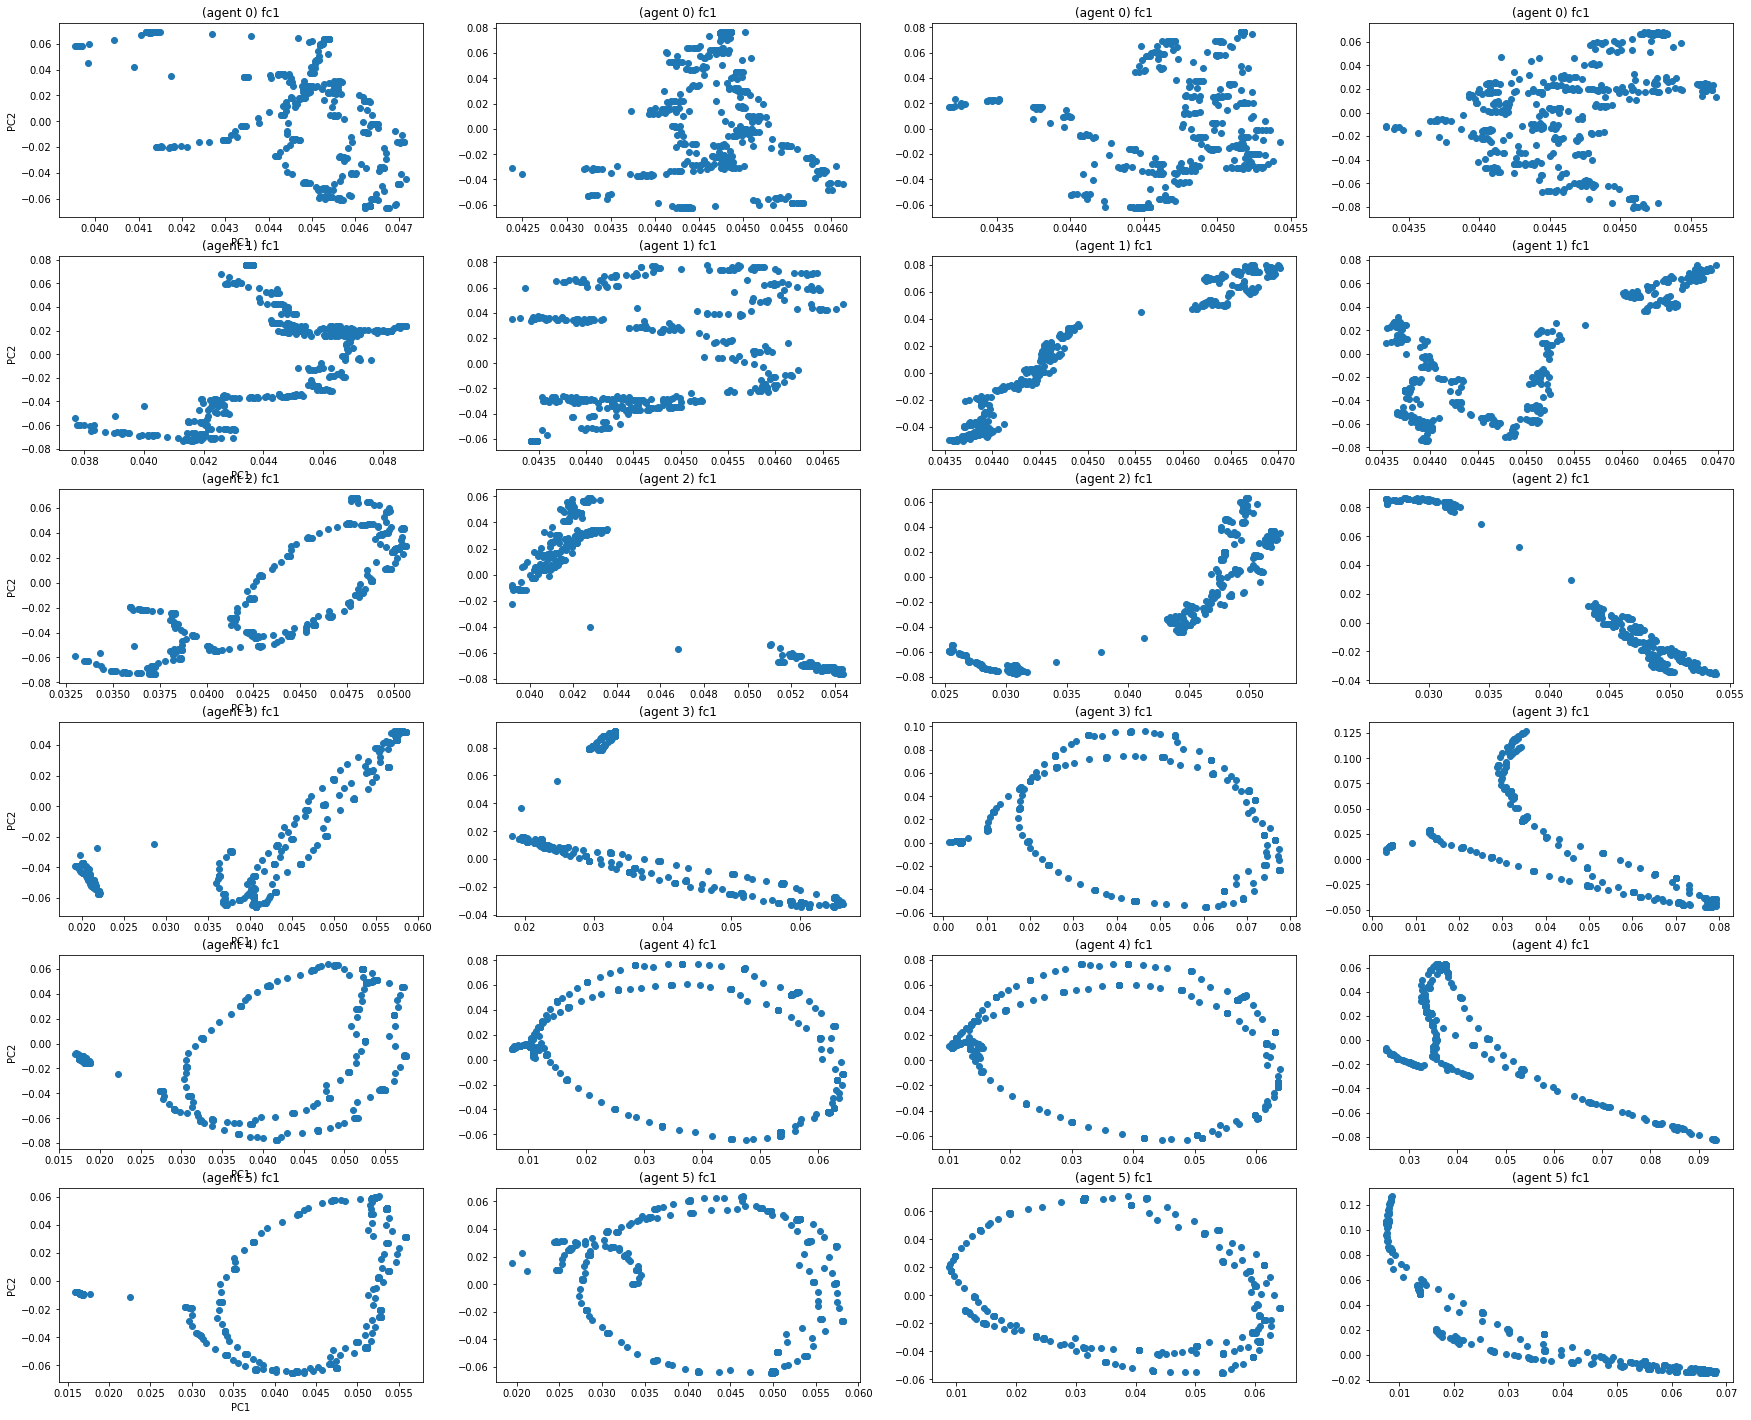

In [7]:
j=1
fig = plt.figure(figsize=(30,25))
for agent_number in range(6):
    for i in range(len(Names_hook)):
        X = np.transpose(activity_layer[0][agent_number][i])
        pca = PCA(n_components = 10) #we have 20 features
        pca.fit(X)
        ax = fig.add_subplot(6,len(Names_hook),j)
        ax.scatter(pca.components_[0],pca.components_[1])
        ax.set_title("(agent %s) %s" % (agent_number, Names_hook[layer]))           # plt.suptitle(table[agent_number][0], fontsize=20)
        if i ==0:
            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')
            
        j+=1
        



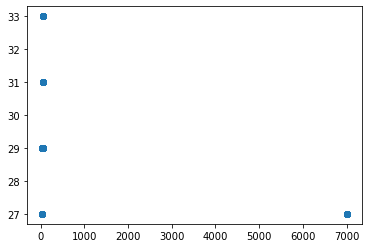

In [42]:
plt.figure()
plt.scatter(Liste_position_agent[0][2][10:100],Liste_position_alien[0][2][10:100])

In [8]:
class CCA_Analysis():
    
    def __init__(self,LENGTH_TRIAL, activity_layer,position_agent,position_alien,action_agent):
        self.activity_layer = activity_layer
        self.position_agent = position_agent[0:LENGTH_TRIAL]
        self.position_alien = position_alien[0:LENGTH_TRIAL]
        self.action_agent = action_agent[0:LENGTH_TRIAL]
        
        self.pca = self.pca_analysis()
        self.df = self.data_frame()
        self.X_mc,self.Y_mc = self.dataset_stand()
        self.cc_res,self.coeff_corr_first_pair,self.coeff_corr_second_pair = self.CCA_analysis()
    
    def pca_analysis(self):
        X = np.transpose(self.activity_layer)
        pca = PCA(n_components = 5) #we have 20 features
        pca.fit(X)
        return pca
    
    def data_frame(self):
        data = {'PC1':self.pca.components_[0],'PC2':self.pca.components_[1],'PC3':self.pca.components_[2],'PC4':self.pca.components_[3],'PC5':self.pca.components_[4], 'Agent_Position':self.position_agent,'Alien_Position':self.position_alien,'Action_agent':self.action_agent}  
        df = pd.DataFrame(data, index =[str(i) for i in range(LENGTH_TRIAL)])  
        return df


    def dataset_stand(self):
        X = self.df[['PC1','PC2','PC3','PC4','PC5']]
        Y = self.df[["Agent_Position","Alien_Position"]]
        X_mc = (X-X.mean())/(X.std())
        Y_mc = (Y-Y.mean())/(Y.std())
        return X_mc,Y_mc

    
    def CCA_analysis(self):
        ca = CCA()
        ca.fit(self.X_mc, self.Y_mc)
        X_c, Y_c = ca.transform(self.X_mc, self.Y_mc)
        
        cc_res = pd.DataFrame({"CCX_1":X_c[:, 0],
                       "CCY_1":Y_c[:, 0],
                       "CCX_2":X_c[:, 1],
                       "CCY_2":Y_c[:, 1],
                       "Actions":self.df.Action_agent.tolist(),
                      })
        
        coeff_corr_first_pair = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0][1]
        coeff_corr_second_pair = np.corrcoef(X_c[:, 1], Y_c[:, 1])[0][1]

        return cc_res,coeff_corr_first_pair,coeff_corr_second_pair

In [16]:
sum_coeff_corr = [[[] for i in range(len(Names_hook))] for episode in range(EPISODES)]
for agent_number in range(6):
    print(agent_number)
    for episode in range(EPISODES):
        for i in range(len(Names_hook)):
            cca_analysis = CCA_Analysis(LENGTH_TRIAL,activity_layer[episode][agent_number][i],Liste_position_agent[episode][agent_number],Liste_position_alien[episode][agent_number],Liste_action_agent[episode][agent_number])
            sum_coeff_corr[episode][i].append(np.abs(cca_analysis.coeff_corr_first_pair)+np.abs(cca_analysis.coeff_corr_second_pair))

In [19]:
tensor_sum_coeff = torch.tensor(sum_coeff_corr)
mean_tensor_sum_coeff = torch.mean(tensor_sum_coeff,axis = 0)
print(mean_tensor_sum_coeff.size())

torch.Size([4, 6])


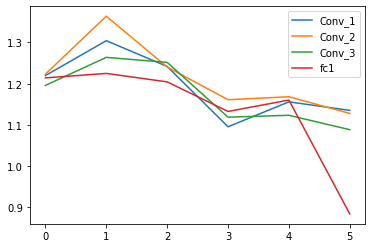

In [20]:
plt.figure()
for i in range(len(Names_hook)):
    plt.plot(range(len(mean_tensor_sum_coeff[i])),mean_tensor_sum_coeff[i],label = Names_hook[i])
plt.legend()

In [31]:
coeff_corr_first = [[[] for i in range(len(Names_hook))] for episode in range(EPISODES)]
coeff_corr_second = [[[] for i in range(len(Names_hook))] for episode in range(EPISODES)]


for agent_number in range(6):
    for episode in range(EPISODES):
        for i in range(len(Names_hook)):
            cca_analysis = CCA_Analysis(LENGTH_TRIAL,activity_layer[episode][agent_number][i],Liste_position_agent[episode][agent_number],Liste_position_alien[episode][agent_number],Liste_action_agent[episode][agent_number])
            coeff_corr_first[episode][i].append(cca_analysis.coeff_corr_first_pair)
            coeff_corr_second[episode][i].append(cca_analysis.coeff_corr_second_pair)
            
tensor_coeff_corr_first = torch.tensor(coeff_corr_first)
mean_tensor_coeff_corr_first   = torch.mean(tensor_coeff_corr_first,axis = 0)            
tensor_coeff_corr_second = torch.tensor(coeff_corr_second)
mean_tensor_coeff_corr_second   = torch.mean(tensor_coeff_corr_second,axis = 0)       

In [32]:
print(mean_tensor_coeff_corr_second.shape)

torch.Size([4, 6])


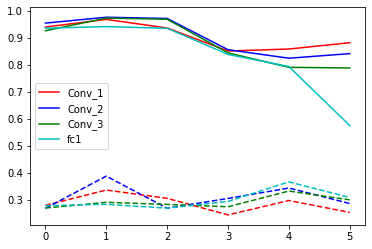

In [33]:
color_code = ["r","b","g","c"]
plt.figure()
for i in range(len(Names_hook)):
    plt.plot(range(len(mean_tensor_coeff_corr_first[i])),mean_tensor_coeff_corr_first[i],color =color_code[i] ,label = Names_hook[i])
    plt.plot(range(len(mean_tensor_coeff_corr_second[i])),mean_tensor_coeff_corr_second[i],"--",color =color_code[i] )


plt.legend()